In [11]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

### EDA/Cleaning

In [12]:
data = pd.read_csv("archive/Occupancy_Estimation.csv")
data.head()

,Date,Time,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
0,2017/12/22,10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0,1
1,2017/12/22,10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0,1
2,2017/12/22,10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.519231,0,0,1
3,2017/12/22,10:51:13,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.388462,0,0,1
4,2017/12/22,10:51:44,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.253846,0,0,1


In [13]:
def eda(data):
  # Calculate basic statistics
  print("Number of rows:", len(data))
  print("Number of columns:", len(data.columns))
  print("\nColumns:", data.columns.tolist())
  print("\nMissing values:", data.isnull().sum().values.sum())
  print("\nBasic statistics:")
  print(data.describe())

In [14]:
eda(data)
## turn into occupied or not occupied
data['Occupied'] = [0 if data['Room_Occupancy_Count'][i] == 0 else 1 for i in range(len(data['Room_Occupancy_Count']))]
print("\n\nProportion of samples where room is occupied:",1 - sum(data['Occupied']) / len(data['Occupied']))

Number of rows: 10129
Number of columns: 19

Columns: ['Date', 'Time', 'S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp', 'S1_Light', 'S2_Light', 'S3_Light', 'S4_Light', 'S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound', 'S5_CO2', 'S5_CO2_Slope', 'S6_PIR', 'S7_PIR', 'Room_Occupancy_Count']

Missing values: 0

Basic statistics:
            S1_Temp       S2_Temp       S3_Temp       S4_Temp      S1_Light  \
count  10129.000000  10129.000000  10129.000000  10129.000000  10129.000000   
mean      25.454012     25.546059     25.056621     25.754125     25.445059   
std        0.351351      0.586325      0.427283      0.356434     51.011264   
min       24.940000     24.750000     24.440000     24.940000      0.000000   
25%       25.190000     25.190000     24.690000     25.440000      0.000000   
50%       25.380000     25.380000     24.940000     25.750000      0.000000   
75%       25.630000     25.630000     25.380000     26.000000     12.000000   
max       26.380000     29.000000     26.190000  

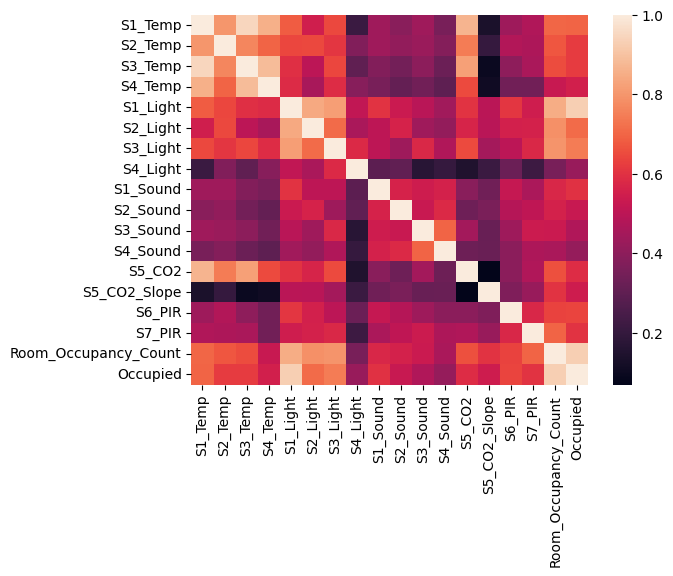

In [15]:
sns.heatmap(data[2:].corr())
plt.show()

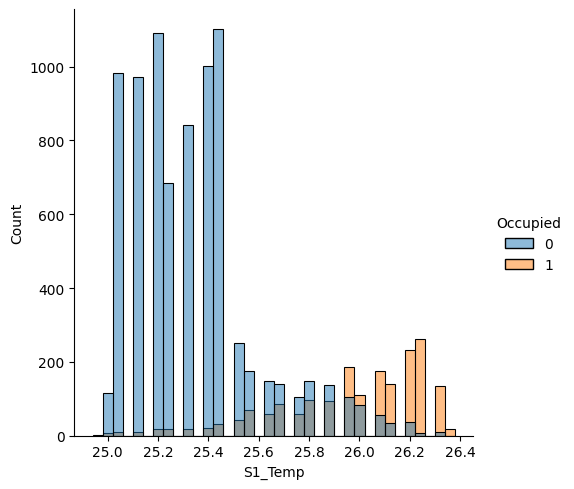

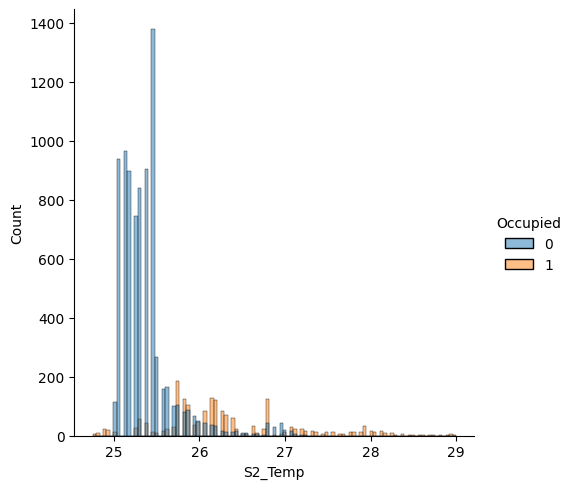

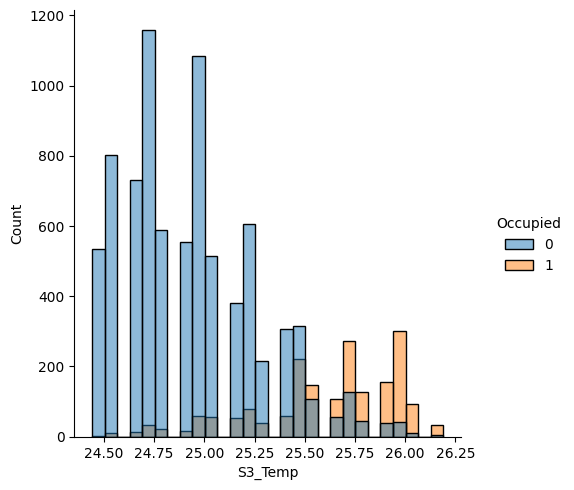

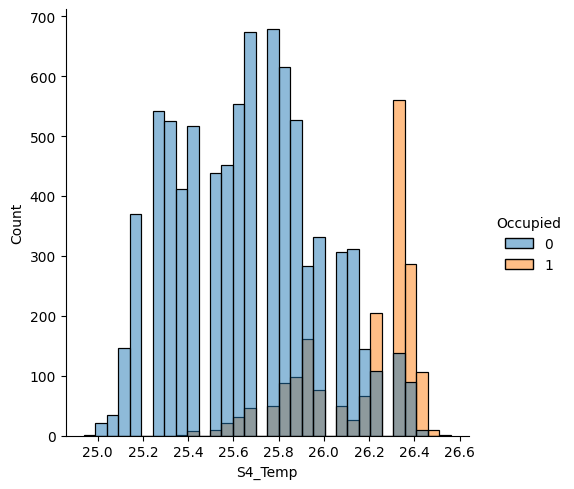

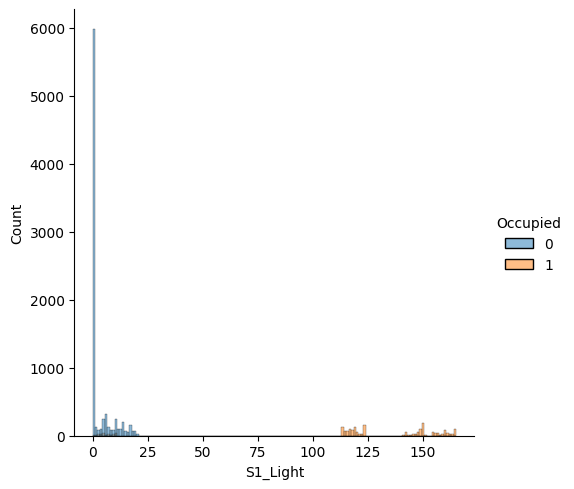

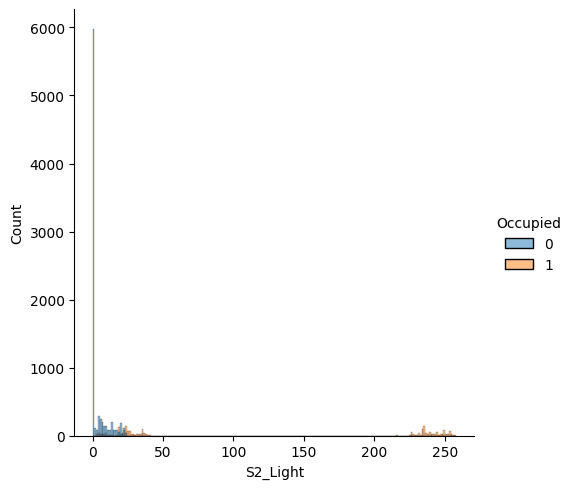

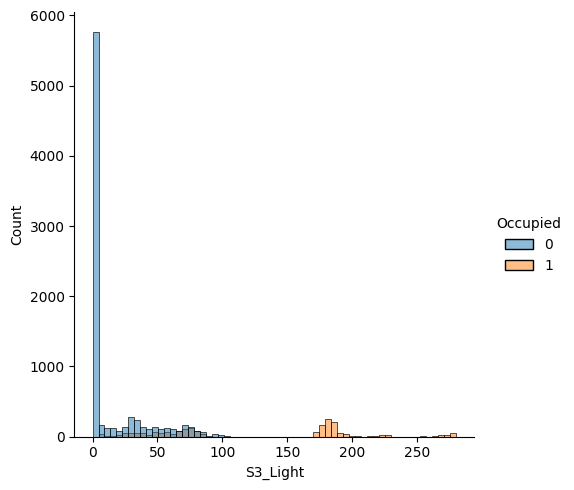

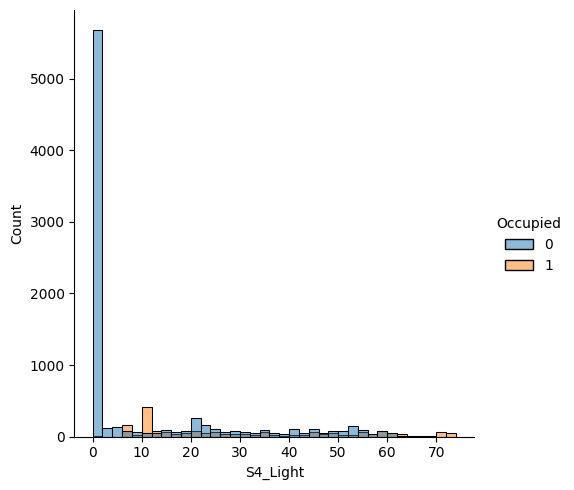

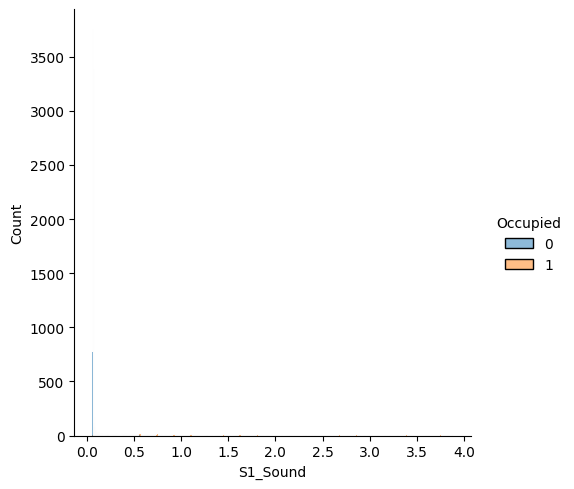

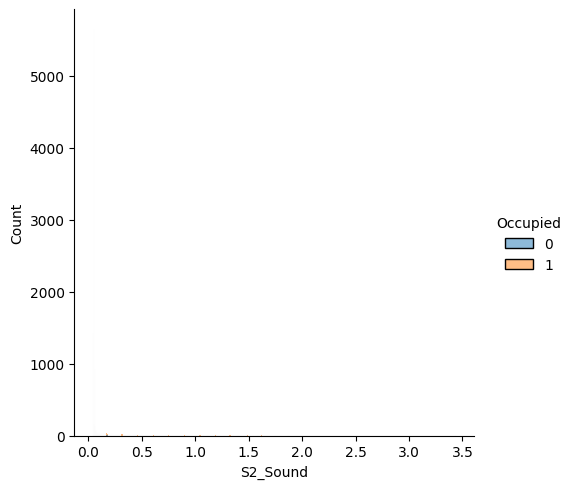

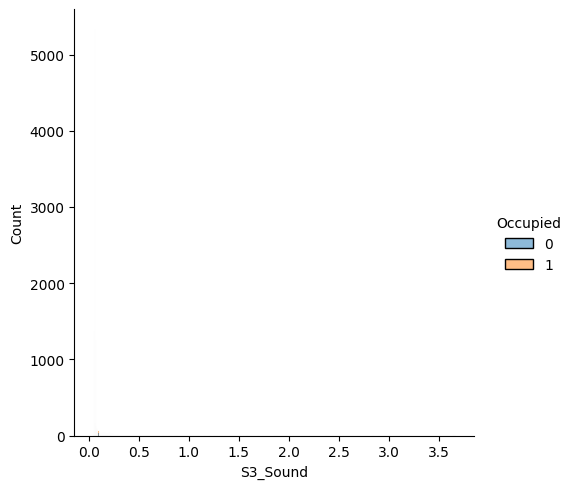

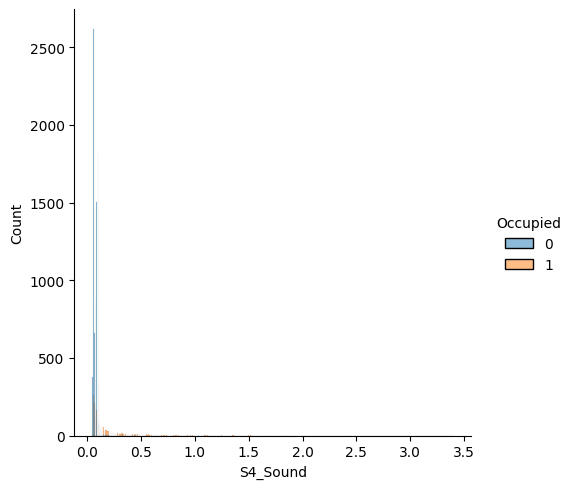

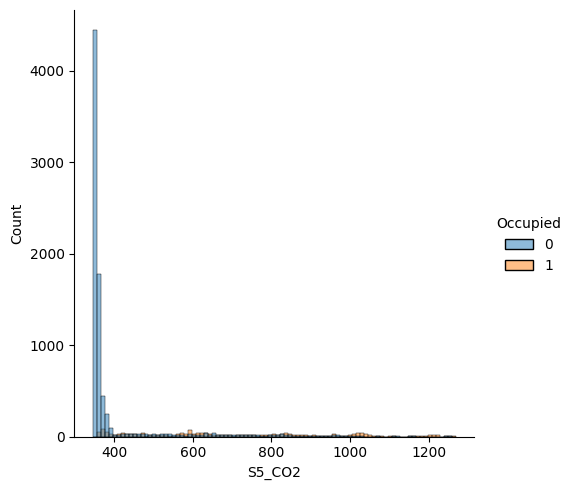

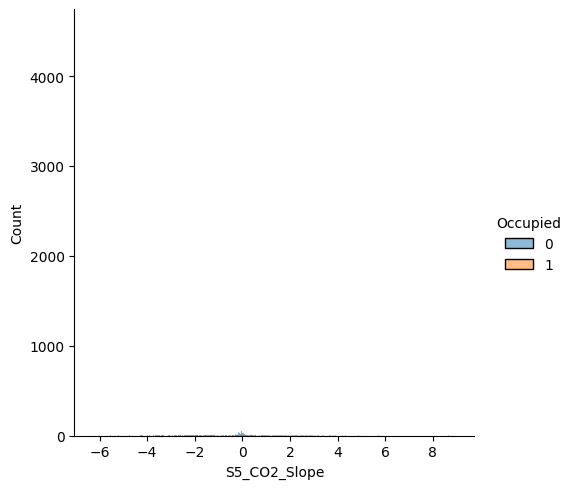

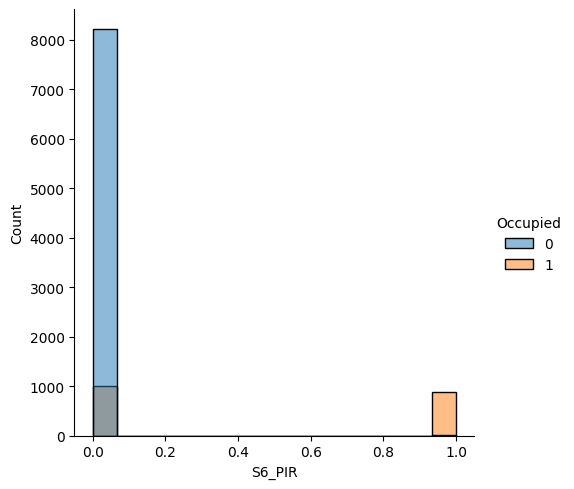

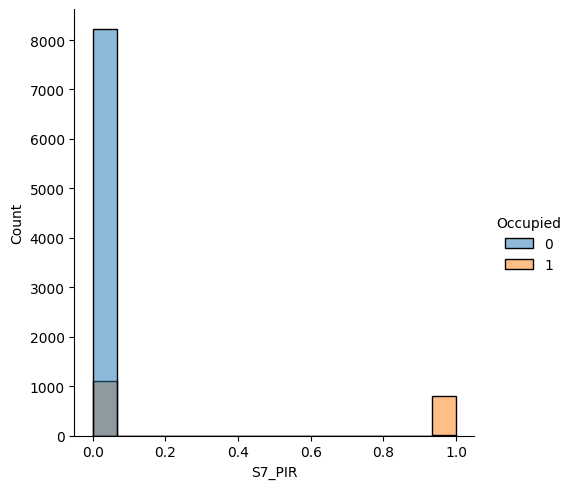

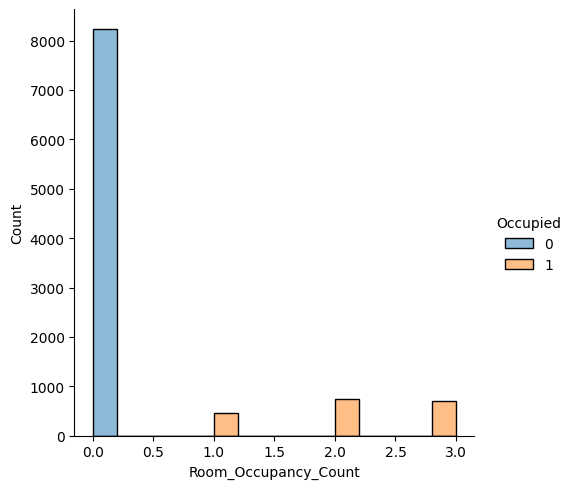

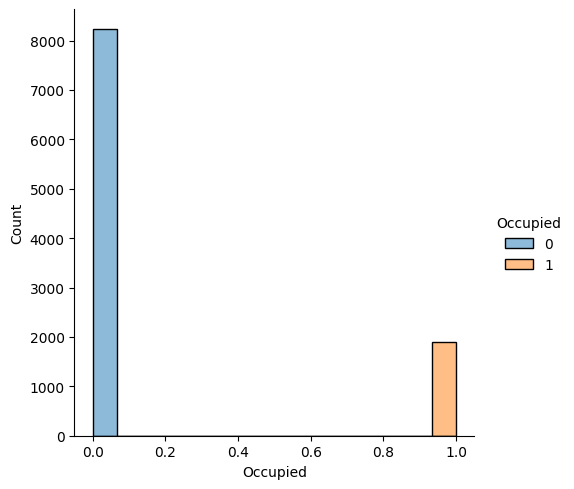

In [16]:
# A heat map showing the correlation between different features
for col in data.columns[2:]:
    sns.displot(data, x = col, hue = "Occupied")

### Train Test Split

In [17]:
def split_data(data):
    X = data.drop(["Date", "Time", "Room_Occupancy_Count", "Occupied"], axis = 1 )
    y = data['Occupied']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = split_data(data)

### GBM

In [18]:
gb_params = {
    'learning_rate': [0.1, 0.2, 0.3,.5,.7],
    'n_estimators': [10, 50, 100, 200, 300, 500],
    'max_depth': [2, 3, 4, 5, 6]
}

# gb classifier
gb = GradientBoostingClassifier()

# do the the grid search
gb_grid = GridSearchCV(gb, gb_params, cv=3)

# train the model
gb_grid.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.1, 0.2, 0.3, 0.5, 0.7],
                         'max_depth': [2, 3, 4, 5, 6],
                         'n_estimators': [10, 50, 100, 200, 300, 500]})

In [19]:
# find the best parameters

gb_best_params = gb_grid.best_params_
gb_best_score = gb_grid.best_score_
print("Best parameters:",gb_best_params)
print("Best Score: ",gb_best_score)

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
Best Score:  0.9996297667530545


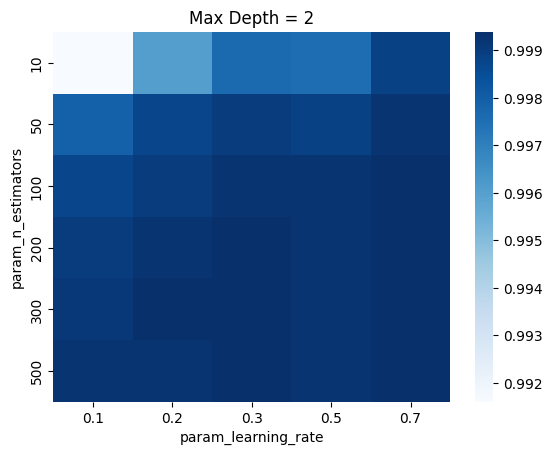

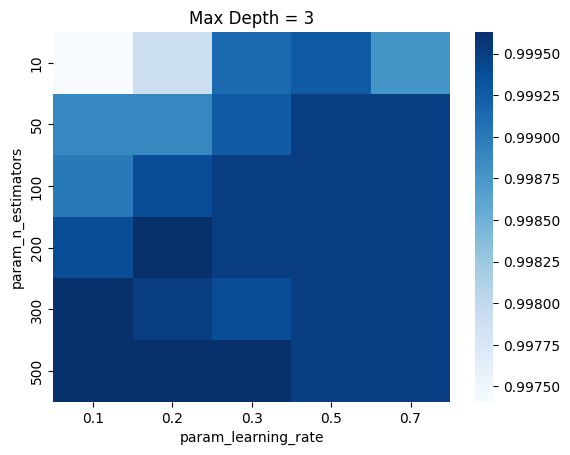

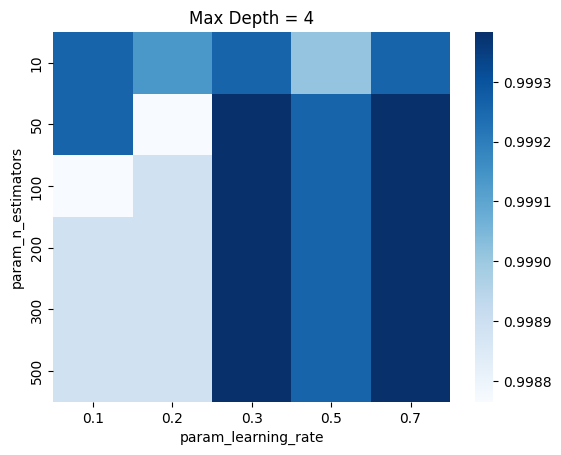

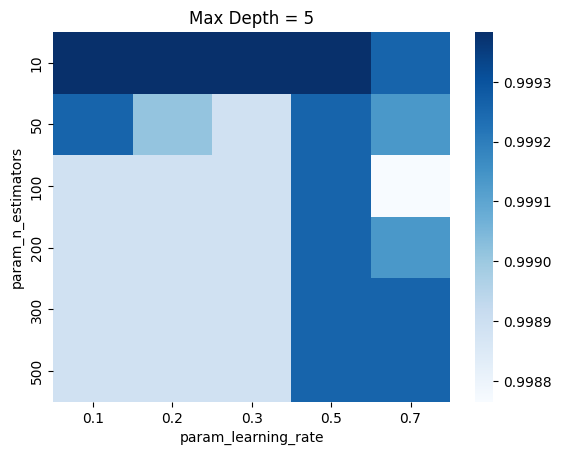

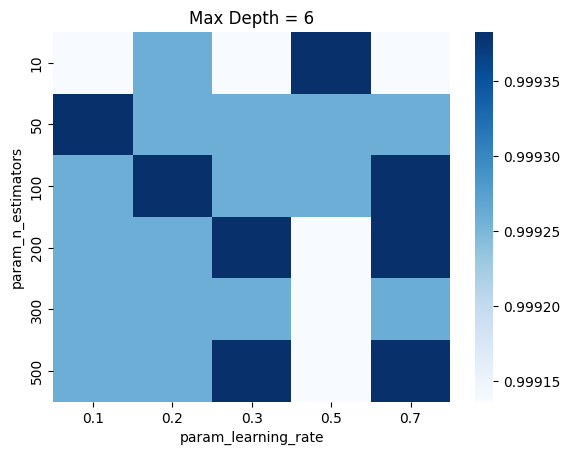

In [20]:
# plot change in accuracy based different parameters
# each plot has a fixed max depth then explores the other parameters

results = pd.DataFrame(gb_grid.cv_results_)
for x in gb_params['max_depth']:
    sns.heatmap(results[results['param_max_depth'] == x].pivot_table(index='param_n_estimators', columns='param_learning_rate', values='mean_test_score'),cmap ="Blues")
    plt.title("Max Depth = "+str(x))
    plt.show()
    

In [21]:
# get the final test accuracy
model = GradientBoostingClassifier(learning_rate=gb_best_params['learning_rate'],
                                   n_estimators=gb_best_params['n_estimators'],
                                   max_depth=gb_best_params['max_depth'])

model.fit(X_train, y_train)
predictions = model.predict(X_test)

from sklearn.metrics import accuracy_score

# Compute the accuracy of the predictions
accuracy = accuracy_score(y_test, predictions)
class_report = classification_report(y_test, predictions)

print("Testing Accuracy:",accuracy)
print(class_report)
print("Confusion Matrix")
print(pd.DataFrame(confusion_matrix(y_test, predictions))

Testing Accuracy: 0.9990128331688055
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1638
           1       1.00      0.99      1.00       388

    accuracy                           1.00      2026
   macro avg       1.00      1.00      1.00      2026
weighted avg       1.00      1.00      1.00      2026

Confusion Matrix
      0    1
0  1638    0
1     2  386


In [22]:
# logistic regression model
log_reg = LogisticRegression()

# cross validation
cv = StratifiedKFold(n_splits=3)

param_grid = {'C': [0.001, 0.01, 0.1, 1,2, 5, 10, 50, 100]}

# grid search
grid_search = GridSearchCV(log_reg, param_grid, cv=cv)

# scale the data
scaler = StandardScaler()
scaler.fit(X_train)

# scale the training data
X_train_scaled = scaler.transform(X_train)

# Fit the model to the training data
grid_search.fit(X_train_scaled, y_train)

# Print the optimal value of C found by grid search
print('Optimal value of C:', grid_search.best_params_['C'])
print('Optimal score:', grid_search.best_score_)

Optimal value of C: 50
Optimal score: 0.9990127113414785


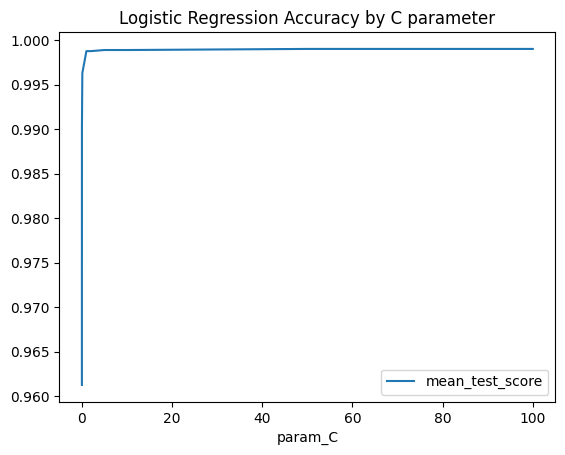

In [23]:
results = pd.DataFrame(grid_search.cv_results_)
results.plot(x = 'param_C', y = 'mean_test_score')
plt.title("Logistic Regression Accuracy by C parameter")
plt.show()

In [24]:
grid_search.best_estimator_.coef_
# grid_search.best_estimator_

array([[-1.56803196e+00, -4.43757795e-01,  1.28224722e+01,
        -8.44369022e+00,  1.11605739e+01,  1.71922319e+00,
         1.59920711e-01, -2.42867584e-01,  3.30803714e-01,
        -8.28898607e-01,  5.93125177e-01, -3.15894486e-02,
        -2.00063893e+00,  4.38477642e+00,  2.16866944e-03,
         6.85458008e-01]])

In [25]:
# get the final test accuracy
model = LogisticRegression(C = grid_search.best_params_['C'])

# train the model on the full training set and make predictions on the testing set
model.fit(X_train_scaled, y_train)
predictions = model.predict(X_test)


# Compute the accuracy of the predictions
accuracy = accuracy_score(y_test, predictions)
class_report = classification_report(y_test, predictions)

print("Testing Accuracy:",accuracy)
print(class_report)
print("Confusion Matrix")
print(pd.DataFrame(confusion_matrix(y_test, predictions)))

Testing Accuracy: 0.9417571569595261
              precision    recall  f1-score   support

           0       0.93      1.00      0.97      1638
           1       1.00      0.70      0.82       388

    accuracy                           0.94      2026
   macro avg       0.97      0.85      0.89      2026
weighted avg       0.95      0.94      0.94      2026

Confusion Matrix
      0    1
0  1638    0
1   118  270


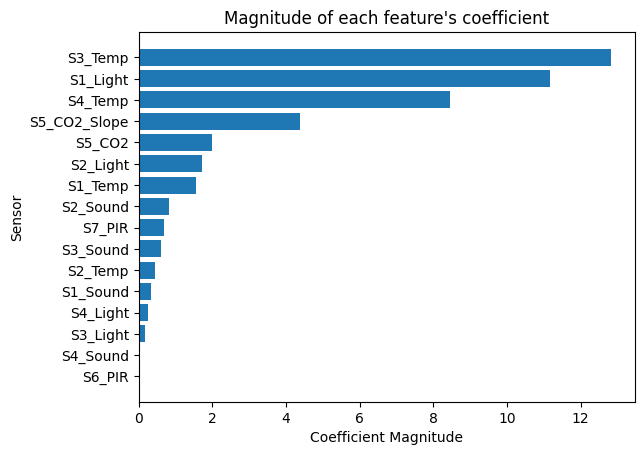

In [26]:
# building graph to see which features have the highest impact on the model

x = ["S1_Temp", "S2_Temp", "S3_Temp", "S4_Temp", "S1_Light", "S2_Light", "S3_Light", "S4_Light", "S1_Sound", "S2_Sound", "S3_Sound", "S4_Sound", "S5_CO2", "S5_CO2_Slope", "S6_PIR", "S7_PIR"]
coefs = pd.DataFrame({
    'features' : x,
    'coef' : np.absolute(model.coef_)[0]
})
coefs = coefs.sort_values('coef')
# figure(figsize=(20, 6), dpi=80)
plt.ylabel("Sensor")
plt.xlabel("Coefficient Magnitude")
plt.barh(coefs['features'],coefs['coef'])
plt.title("Magnitude of each feature's coefficient")
plt.show()